In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
import logging
import multiprocessing
import os
import pprint
import re

In [5]:
#untuk nampilkan info log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
with open ("tokenkalimat-NEW.txt", "r",encoding='utf-8') as file:
    dataset=file.read()
    print("panjang korpus {0:,} karakter".format(len(dataset)))

panjang korpus 924,167 karakter


In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize
raw_sentences = sent_tokenize(dataset)
print(raw_sentences[1])

pernapasan adalah proses menghirup udara atau pergerakan udara dari luar yang mengandung oksigen o₂ masuk ke dalam tubuh atau paru-paru serta menghembuskan udara yang mengandung karbon dioksida co₂ sebagai sisa dari oksidasi ke luar dari tubuh.


In [10]:
sentences = []
def sentence_to_wordlist(raw):
    words = raw.split()
    return words

for raw_sentence in raw_sentences:
    #print(raw_sentence[0:3000])
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [11]:
len(sentences)

6492

In [12]:
print(raw_sentences[1])
print(sentence_to_wordlist(raw_sentences[1]))

pernapasan adalah proses menghirup udara atau pergerakan udara dari luar yang mengandung oksigen o₂ masuk ke dalam tubuh atau paru-paru serta menghembuskan udara yang mengandung karbon dioksida co₂ sebagai sisa dari oksidasi ke luar dari tubuh.
['pernapasan', 'adalah', 'proses', 'menghirup', 'udara', 'atau', 'pergerakan', 'udara', 'dari', 'luar', 'yang', 'mengandung', 'oksigen', 'o₂', 'masuk', 'ke', 'dalam', 'tubuh', 'atau', 'paru-paru', 'serta', 'menghembuskan', 'udara', 'yang', 'mengandung', 'karbon', 'dioksida', 'co₂', 'sebagai', 'sisa', 'dari', 'oksidasi', 'ke', 'luar', 'dari', 'tubuh.']


In [13]:
token_count = sum([len(sentence) for sentence in sentences])
print("Korpus berisi {0:,} tokens".format(token_count))

Korpus berisi 121,403 tokens


In [14]:
#train word2vec

num_features = 300

#minimum word count threshold
min_word_count = 3

#number of thread to run in paralel
num_workers = multiprocessing.cpu_count()

#context window length
context_size = 10

#downsample setting for frequent word, rate 0 and 1e-5, dan seberapa sering digunakan
downsampling = 1e-3
seed = 1


In [15]:
W2vec = w2v.Word2Vec(
    sg=0,
    hs=1,
    compute_loss=True,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size
)

In [16]:
W2vec.build_vocab(sentences)

2020-08-10 23:16:25,187 : INFO : collecting all words and their counts
2020-08-10 23:16:25,188 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-10 23:16:25,229 : INFO : collected 9656 word types from a corpus of 121403 raw words and 6492 sentences
2020-08-10 23:16:25,230 : INFO : Loading a fresh vocabulary
2020-08-10 23:16:25,251 : INFO : effective_min_count=3 retains 4170 unique words (43% of original 9656, drops 5486)
2020-08-10 23:16:25,252 : INFO : effective_min_count=3 leaves 114431 word corpus (94% of original 121403, drops 6972)
2020-08-10 23:16:25,380 : INFO : deleting the raw counts dictionary of 9656 items
2020-08-10 23:16:25,382 : INFO : sample=0.001 downsamples 52 most-common words
2020-08-10 23:16:25,383 : INFO : downsampling leaves estimated 89957 word corpus (78.6% of prior 114431)
2020-08-10 23:16:25,390 : INFO : constructing a huffman tree from 4170 words
2020-08-10 23:16:25,572 : INFO : built huffman tree with maximum node depth 15
20

In [17]:
print("panjang vocab Word2Vec:", len(W2vec.wv.vocab))

panjang vocab Word2Vec: 4170


In [18]:
#train model on sentences
W2vec.train(sentences, epochs=W2vec.epochs, total_examples=W2vec.corpus_count)

#save model
if not os.path.exists("trained"):
    os.makedirs("trained")

2020-08-10 23:17:09,595 : INFO : training model with 4 workers on 4170 vocabulary and 300 features, using sg=0 hs=1 sample=0.001 negative=5 window=10
2020-08-10 23:17:10,274 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-10 23:17:10,281 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-10 23:17:10,286 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-10 23:17:10,296 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-10 23:17:10,298 : INFO : EPOCH - 1 : training on 121403 raw words (89881 effective words) took 0.5s, 176457 effective words/s
2020-08-10 23:17:10,711 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-10 23:17:10,716 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-10 23:17:10,732 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-10 23:17:10,740 : INFO : worker thread finished; awaiting finish of 0 m

In [19]:
W2vec.save(os.path.join("trained", "w2vec.w2v"))

2020-08-10 23:17:44,585 : INFO : saving Word2Vec object under trained\w2vec.w2v, separately None
2020-08-10 23:17:44,587 : INFO : not storing attribute vectors_norm
2020-08-10 23:17:44,590 : INFO : not storing attribute cum_table
2020-08-10 23:17:45,152 : INFO : saved trained\w2vec.w2v


In [20]:
#load model
W2vec = w2v.Word2Vec.load(os.path.join("trained", "W2vec.w2v"))

2020-08-10 23:18:24,827 : INFO : loading Word2Vec object from trained\W2vec.w2v
2020-08-10 23:18:25,115 : INFO : loading wv recursively from trained\W2vec.w2v.wv.* with mmap=None
2020-08-10 23:18:25,116 : INFO : setting ignored attribute vectors_norm to None
2020-08-10 23:18:25,117 : INFO : loading vocabulary recursively from trained\W2vec.w2v.vocabulary.* with mmap=None
2020-08-10 23:18:25,119 : INFO : loading trainables recursively from trained\W2vec.w2v.trainables.* with mmap=None
2020-08-10 23:18:25,120 : INFO : setting ignored attribute cum_table to None
2020-08-10 23:18:25,121 : INFO : loaded trained\W2vec.w2v


In [21]:
#squash dimensionality to 2
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [22]:
#put it all into a giant matrix
all_word_vectors_matrix = W2vec.wv.syn0
print(all_word_vectors_matrix)

[[-0.24478266 -0.226663   -0.05594391 ...  0.24059016 -0.4397089
  -0.3082923 ]
 [ 0.32164282  0.00710829 -0.05612736 ...  0.15427828 -0.01928232
  -0.06207159]
 [-0.1594138  -0.06399797  0.01223606 ...  0.1194519  -0.03366546
  -0.16154535]
 ...
 [-0.00583709 -0.01472262  0.01329877 ...  0.0134404  -0.05378196
  -0.02367529]
 [-0.03482389 -0.01022035 -0.00958572 ... -0.00544981  0.00436708
  -0.00657194]
 [ 0.00075201 -0.01890516 -0.01528563 ... -0.00686005 -0.04912762
  -0.04505155]]


C:\Users\Selina\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [23]:
#train t sne
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [24]:
#visualisasi vektor jadi 2d
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[W2vec.wv.vocab[word].index])
            for word in W2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

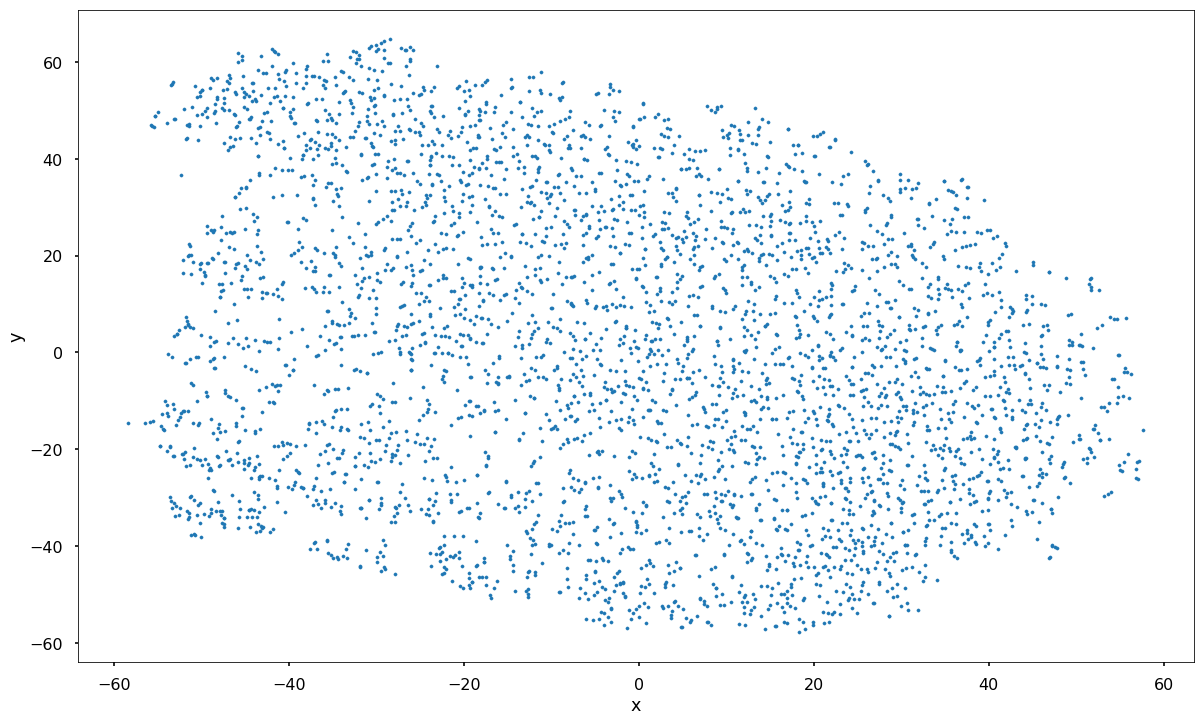

In [25]:
#visualisasikan
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [26]:
#dimensi 200, windows 
W2vec.wv.most_similar("grayscale", topn=6)

2020-08-10 23:20:51,144 : INFO : precomputing L2-norms of word weight vectors


[('segmentasi', 0.9188476800918579),
 ('segmentation', 0.9147875308990479),
 ('contrast', 0.9129440188407898),
 ('grayscaling', 0.909874677658081),
 ('aktivasi', 0.9097235202789307),
 ('optimizer', 0.9088183045387268)]

In [27]:
W2vec.wv.most_similar("enkripsi")

[('dekripsi', 0.9484173059463501),
 ('plainteks', 0.9326151609420776),
 ('dienkripsi', 0.9213732481002808),
 ('ciphertext', 0.9161216020584106),
 ('kunci', 0.8949669599533081),
 ('plaintext', 0.888558030128479),
 ('cipherteks', 0.8855087757110596),
 ('sama', 0.882301926612854),
 ('2-bit', 0.8758023381233215),
 ('dekripsi.', 0.8726695775985718)]

In [28]:
W2vec.wv.most_similar("kompresi")

[('code', 0.9115353226661682),
 ('file.', 0.9082618355751038),
 ('codes', 0.9027690291404724),
 ('fibonacci', 0.9024911522865295),
 ('elias', 0.8928587436676025),
 ('dikompresi', 0.8873296976089478),
 ('g1', 0.8845429420471191),
 ('mengkompresi', 0.881920576095581),
 ('alternate', 0.8813444375991821),
 ('jpg', 0.8745254278182983)]

In [29]:
#cosine similarity
W2vec.wv.similarity(w1="jaringan",w2="sinyal")

0.6193118

In [30]:
#cosine similarity
W2vec.wv.similarity(w1="citra",w2="enkripsi")

0.4747374

In [88]:
###########

In [31]:
#dengan dataset mala
with open ("mala_results_clean.txt", "r",encoding='utf-8') as file:
    dataset=file.read()
    print("panjang korpus {0:,} karakter".format(len(dataset)))

from nltk.tokenize import sent_tokenize, word_tokenize
raw_sentences = sent_tokenize(dataset)
print(raw_sentences[1])

sentences = []
def sentence_to_wordlist(raw):
    words = raw.split()
    return words

for raw_sentence in raw_sentences:
    #print(raw_sentence[0:3000])
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

panjang korpus 56,353,917 karakter
medan      desember          albert               iii universitas sumatera utara x c penghargaan    puji dan syukur penulis panjatkan kepada tuhan yang maha pemurah dan maha penyayang  dengan melimpahkan kurnia-nya kertas kajian ini berhasil diselesaikan dalam waktu yang telah ditetapkan.


In [32]:
token_count = sum([len(sentence) for sentence in sentences])
print("Korpus berisi {0:,} tokens".format(token_count))

Korpus berisi 7,166,099 tokens


In [33]:
#train word2vec

num_features = 300

#minimum word count threshold
min_word_count = 3

#number of thread to run in paralel
num_workers = multiprocessing.cpu_count()

#context window length
context_size = 10

#downsample setting for frequent word, rate 0 and 1e-5, dan seberapa sering digunakan
downsampling = 1e-3
seed = 1

W2vec = w2v.Word2Vec(
    sg=0,
    hs=1,
    compute_loss=True,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size
)

W2vec.build_vocab(sentences)

2020-08-10 23:22:48,605 : INFO : collecting all words and their counts
2020-08-10 23:22:48,606 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-10 23:22:48,652 : INFO : PROGRESS: at sentence #10000, processed 160744 words, keeping 11923 word types
2020-08-10 23:22:48,686 : INFO : PROGRESS: at sentence #20000, processed 311477 words, keeping 18200 word types
2020-08-10 23:22:48,724 : INFO : PROGRESS: at sentence #30000, processed 470760 words, keeping 25559 word types
2020-08-10 23:22:48,758 : INFO : PROGRESS: at sentence #40000, processed 612181 words, keeping 29030 word types
2020-08-10 23:22:48,795 : INFO : PROGRESS: at sentence #50000, processed 774575 words, keeping 34289 word types
2020-08-10 23:22:48,855 : INFO : PROGRESS: at sentence #60000, processed 914446 words, keeping 39161 word types
2020-08-10 23:22:48,889 : INFO : PROGRESS: at sentence #70000, processed 1026228 words, keeping 41195 word types
2020-08-10 23:22:48,954 : INFO : PROGRESS: at

In [34]:
print("panjang vocab:", len(W2vec.wv.vocab))

panjang vocab: 49489


In [35]:
#train model on sentences
W2vec.train(sentences, epochs=W2vec.epochs, total_examples=W2vec.corpus_count)

#save model
if not os.path.exists("trained"):
    os.makedirs("trained")

2020-08-10 23:23:18,003 : INFO : training model with 4 workers on 49489 vocabulary and 300 features, using sg=0 hs=1 sample=0.001 negative=5 window=10
2020-08-10 23:23:19,026 : INFO : EPOCH 1 - PROGRESS: at 3.99% examples, 308264 words/s, in_qsize 7, out_qsize 0
2020-08-10 23:23:20,075 : INFO : EPOCH 1 - PROGRESS: at 8.48% examples, 307735 words/s, in_qsize 8, out_qsize 0
2020-08-10 23:23:21,096 : INFO : EPOCH 1 - PROGRESS: at 13.49% examples, 320561 words/s, in_qsize 7, out_qsize 0
2020-08-10 23:23:22,114 : INFO : EPOCH 1 - PROGRESS: at 20.05% examples, 321787 words/s, in_qsize 8, out_qsize 0
2020-08-10 23:23:23,121 : INFO : EPOCH 1 - PROGRESS: at 24.71% examples, 320012 words/s, in_qsize 8, out_qsize 1
2020-08-10 23:23:24,148 : INFO : EPOCH 1 - PROGRESS: at 28.39% examples, 312551 words/s, in_qsize 8, out_qsize 1
2020-08-10 23:23:25,189 : INFO : EPOCH 1 - PROGRESS: at 32.02% examples, 304316 words/s, in_qsize 7, out_qsize 0
2020-08-10 23:23:26,207 : INFO : EPOCH 1 - PROGRESS: at 35.7

2020-08-10 23:24:20,128 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-10 23:24:20,129 : INFO : EPOCH - 3 : training on 7166099 raw words (5721679 effective words) took 21.5s, 265832 effective words/s
2020-08-10 23:24:21,161 : INFO : EPOCH 4 - PROGRESS: at 3.50% examples, 265234 words/s, in_qsize 8, out_qsize 0
2020-08-10 23:24:22,206 : INFO : EPOCH 4 - PROGRESS: at 7.67% examples, 279697 words/s, in_qsize 7, out_qsize 0
2020-08-10 23:24:23,230 : INFO : EPOCH 4 - PROGRESS: at 11.80% examples, 273083 words/s, in_qsize 7, out_qsize 0
2020-08-10 23:24:24,236 : INFO : EPOCH 4 - PROGRESS: at 16.40% examples, 279958 words/s, in_qsize 7, out_qsize 0
2020-08-10 23:24:25,266 : INFO : EPOCH 4 - PROGRESS: at 20.99% examples, 270022 words/s, in_qsize 8, out_qsize 0
2020-08-10 23:24:26,281 : INFO : EPOCH 4 - PROGRESS: at 24.92% examples, 268786 words/s, in_qsize 7, out_qsize 0
2020-08-10 23:24:27,316 : INFO : EPOCH 4 - PROGRESS: at 29.00% examples, 274007 words/s, in_qsi

In [36]:
W2vec.save(os.path.join("trained", "w2vec-mala.w2v"))

2020-08-10 23:25:52,866 : INFO : saving Word2Vec object under trained\w2vec-mala.w2v, separately None
2020-08-10 23:25:52,867 : INFO : storing np array 'vectors' to trained\w2vec-mala.w2v.wv.vectors.npy
2020-08-10 23:25:53,429 : INFO : not storing attribute vectors_norm
2020-08-10 23:25:53,429 : INFO : storing np array 'syn1' to trained\w2vec-mala.w2v.trainables.syn1.npy
2020-08-10 23:25:54,133 : INFO : storing np array 'syn1neg' to trained\w2vec-mala.w2v.trainables.syn1neg.npy
2020-08-10 23:25:54,929 : INFO : not storing attribute cum_table
2020-08-10 23:25:55,562 : INFO : saved trained\w2vec-mala.w2v
